In [1]:
import pandas as pd
import numpy as np
import gzip
import sys
import os
from pyfaidx import Fasta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Get absolute path for gen_targ_dfs.py, and edit it for cas_object.py
ef_path = os.path.dirname(os.getcwd())
cas_obj_path = ef_path.replace('manuscript_analyses','scripts/')
sys.path.append(cas_obj_path)
import cas_object as cas_obj

%matplotlib inline

# Identification of PAM sites in the hg19 and hg38 human reference genomes

The first step in any AlleleAnalyzer cohort analysis is determining where the PAM sites are in the reference genome. This is so one can determine when variants occur in or near an existing PAM. 

The fasta files for these reference genomes were downloaded from the [UCSC Genome Browser](https://genome.ucsc.edu/index.html.

The relevant script from AlleleAnalyzer to annotate PAM sites in a reference genome is `pam_pos_genome.py` in `preprocessing/find_pams_in_reference/`. 

**Sample command for chromosome 1 analysing all Cas varieties from AlleleAnalyzer manuscript:**

`python pam_pos_genome.py chr1 hg38.fa cpf1,SpCas9,SpCas9_VRER,SpCas9_EQR,SpCas9_VQR_1,\
SpCas9_VQR_2,StCas9,StCas9_2,SaCas9,SaCas9_KKH,\
nmCas9,cjCas9 output_directory/`

We parallelized this by chromosome using the QB3 cluster at UCSF. PAM sites analyzed for each Cas are shown in Supplementary Figure 1. Adding a new PAM or Cas enzyme can be simply done by editing that file `AlleleAnalyzer/scripts/CAS_LIST.txt `. This takes between a few minutes to around a half hour depending on the size of the chromosome and the type of computer you're using.

# Visualization of PAM sites

In order to visualize these PAM sites, we generated BED files for visualization in the [UCSC genome browser](https://genome.ucsc.edu/FAQ/FAQformat.html). This process is shown below.

PAM table: 

| **Cas Type** | **Alternative Names** | **PAM Site** | **PAM Size** |
| --- | --- | --- | --- |
| SpCas9 | SpCas9 | NGG | 2 |
| SpCas9-V1 | SaCas9_KKH | NGCG | 3 |
| SpCas9-V2 | SpCas9_EQR | NGAG | 3 |
| SpCas9-V3 | SpCas9_VQR_1 and SpCas9_VQR_2 | NGAN or NGNG | 2 |
| SaCas9 | SaCaas9 | NNGRRT | 4 |
| SaCas9-V1 | SpCas9_VRER | NNNRRT | 3 |
| nmCas9 | nmCas9 | NNNNGATT | 4 |
| cpf1 | cpf1 | TTTN | 3 |
| StCas9-V1 | StCas9_1 | NNAGAA | 4 |
| StCas9-V2 | StCas9_2| NGGNG | 4 |
| cjCas9 | cjCas9 | NNNNACA | 3 |

BED files were generated with the scripts `pam_beds_hg38.py` and `pam_beds_hg19.py`, with BED headers prepended with the following commands. For hg38 the Python script took ~5.5 hours to run.

`sed -i.old '1s;^;track name="pams_hg38" description="PAM sites hg38" itemRgb="On"\n;' pams_hg38.bed`


`sed -i.old '1s;^;track name="pams_hg19" description="PAM sites hg19" itemRgb="On"\n;' /pollard/data/projects/AlleleAnalyzer_data/pam_beds/pams_hg19.bed`

In [3]:
cas_to_colors = {
'SpCas9':'0,0,255',
'SpCas9_VRER':'102,0,204',
'SpCas9_EQR':'255,0,255',
'SpCas9_VQR_1':'255,0,102',
'SpCas9_VQR_2':'255,0,0',
'StCas9':'255,102,0',
'StCas9_2':'255,204,0',
'SaCas9':'0,153,0',
'SaCas9_KKH':'0,255,0',
'nmCas9':'0,204,153',
'cjCas9':'0,102,102',
'cpf1':'0,153,255'
}

In [5]:
pams = pd.read_csv('/pollard/data/projects/AlleleAnalyzer_data/pam_beds_hg19/head_pams_hg19_sorted.bed',
                   sep='\t', header=None, skiprows=1, names=['chrom','start','stop','cas','blah','strand',
                                                            'start_','stop_','color'])
pams['cas_'] = pams['cas'].str[:-1]
pams['color_'] = pams['cas_'].map(cas_to_colors)

pams.head()

,chrom,start,stop,cas,blah,strand,start_,stop_,color,cas_,color_
0,chr1,10002,10008,SaCas9_KKH-,0,-,10002,10008,"0.319809,0.770914,0.411152",SaCas9_KKH,"0,255,0"
1,chr1,10003,10006,SpCas9-,0,-,10003,10006,"0.267004,0.004874,0.329415",SpCas9,"0,0,255"
2,chr1,10003,10007,SpCas9_VQR_2-,0,-,10003,10007,"0.177423,0.437527,0.557565",SpCas9_VQR_2,"255,0,0"
3,chr1,10004,10007,SpCas9-,0,-,10004,10007,"0.267004,0.004874,0.329415",SpCas9,"0,0,255"
4,chr1,10008,10014,SaCas9-,0,-,10008,10014,"0.166383,0.690856,0.496502",SaCas9,"0,153,0"


In [8]:
# for cas in cas_to_colors.keys():
#     cas_color = cas_to_colors[cas]
#     pams.query('cas_ == @cas')[['chrom','start','stop','cas_','blah','strand',
#       'start_','stop_','color_']].to_csv(f'/pollard/data/projects/AlleleAnalyzer_data/pam_beds_hg19/test_{cas}.bed',
#            sep='\t', index=None, header=[f'track name={cas} description={cas} color={cas_color},']
#                                                       +['']*8)

## hg19

In [11]:
track_headers = []

for cas in cas_to_colors.keys():
    color=cas_to_colors[cas]
    track_headers.append(f'track type=bigBed name={cas} description={cas} visibility=full color={color}, bigDataUrl=http://lighthouse.ucsf.edu/public_files_no_password/excisionFinderData_public/ucsc_track_hub/hg19_pams/{cas}_ucsc.bb')

with open('track_headers_hg19.txt','w') as f:
    for header in track_headers:
        f.write(header + '\n\n')

## hg38

In [4]:
track_headers = []

for cas in cas_to_colors.keys():
    color=cas_to_colors[cas]
    track_headers.append(f'track type=bigBed name={cas} description={cas} visibility=full color={color}, bigDataUrl=http://lighthouse.ucsf.edu/public_files_no_password/excisionFinderData_public/ucsc_track_hub/hg38_pams/{cas}_ucsc.bb')

with open('track_headers_hg38.txt','w') as f:
    for header in track_headers:
        f.write(header + '\n\n')

In [33]:
%%bash

cat /pollard/data/projects/AlleleAnalyzer_data/pam_beds_hg19/test_*.bed > /pollard/data/projects/AlleleAnalyzer_data/pam_beds_hg19/test.bed

cat: /pollard/data/projects/AlleleAnalyzer_data/pam_beds_hg19/test_*.bed: No such file or directory


In [7]:
pams[['chrom','start','stop','cas_','blah','strand',
      'start_','stop_','color_']].to_csv('/pollard/data/projects/AlleleAnalyzer_data/pam_beds_hg19/test.bed',
           sep='\t', header=None, index=None)

# Analysis of prevalence of PAM sites for each type of Cas enzyme in the human reference genomes

Different PAM sites occur at different frequencies in the genome, which we determined was highly correlated with size of the non-degenerate portion of the PAM motif, demonstrated below. First, number of occurrences of each PAM site is evaluated with `get_n_occurrences_pams.py`.

**hg19:**

`python get_n_occurrences_pams.py /pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg19/ /pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg19/` 

This took < 3 minutes to run.


**hg38:**

`python get_n_occurrences_pams.py /pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg38/ /pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg38/` 

This took ~ 3.5 minutes to run.

In [2]:
pam_sizes = {'SpCas9':2, 'SpCas9-V1':3, 'SpCas9-V2':3, 'SpCas9-V3':2, 
             'SaCas9':4, 'SaCas9-V1':3, 'nmCas9':4, 'cpf1':3, 
             'StCas9-V1':4, 'StCas9-V2':4, 'cjCas9':3}

In [3]:
cas_dict = np.load('/pollard/data/projects/AlleleAnalyzer_data/cas_abbrev_dict.npy').item()
pam_presence_dict = np.load('/pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg19/n_pams_per_cas.npy').item()
pam_presence_df = pd.DataFrame.from_dict(pam_presence_dict, orient='index')
pam_presence_df.columns = ['n_occurrences']
pam_presence_df['Cas'] = pam_presence_df.index
cas_list = list(pam_sizes.keys())
pam_presence_df = pam_presence_df.replace(cas_dict)
pam_presence_df['in_list'] = pam_presence_df['Cas'].isin(cas_list)
pam_presence_df = pam_presence_df.query('in_list')[['n_occurrences','Cas']]
pam_presence_df['PAM_size'] = pam_presence_df.apply(lambda row: pam_sizes[row['Cas']], axis=1)

pam_presence_df.sort_values(by='n_occurrences', ascending=False)

,n_occurrences,Cas,PAM_size
SpCas9_VQR,610826829,SpCas9-V3,2
SaCas9_KKH,377660720,SaCas9-V1,3
SpCas9,298215692,SpCas9,2
cpf1,219915585,cpf1,3
cjCas9,115415889,cjCas9,3
SpCas9_EQR,96335412,SpCas9-V2,3
SaCas9,81995513,SaCas9,4
StCas9_2,73084178,StCas9-V2,4
StCas9,44842077,StCas9-V1,4
nmCas9,23337243,nmCas9,4


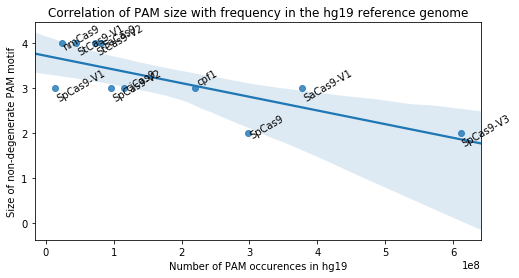

In [13]:
# plot relationship of PAM size to presence in genome
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
p = sns.regplot('n_occurrences', 'PAM_size', data=pam_presence_df, ci=95)
counter = -1
for cas in pam_presence_df.Cas.tolist():
    counter += 1
    if cas == 'cjCas9':
        p.annotate(cas, xy=(pam_presence_df.n_occurrences.tolist()[counter],pam_presence_df.PAM_size.tolist()[counter]),
              rotation=30, xytext=(pam_presence_df.n_occurrences.tolist()[counter]+0.6,
                                   pam_presence_df.PAM_size.tolist()[counter]+0.28))
    else:
        p.annotate(cas, xy=(pam_presence_df.n_occurrences.tolist()[counter],pam_presence_df.PAM_size.tolist()[counter]),
              rotation=30, xytext=(pam_presence_df.n_occurrences.tolist()[counter],
                                   pam_presence_df.PAM_size.tolist()[counter]+0.28))\
        
plt.xlabel('Number of PAM occurences in hg19')
plt.ylabel('Size of non-degenerate PAM motif')
plt.title('Correlation of PAM size with frequency in the hg19 reference genome')

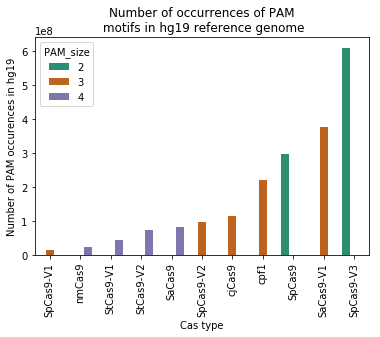

In [7]:
p = sns.barplot(x='Cas',y='n_occurrences',hue='PAM_size',data=pam_presence_df.sort_values(by='n_occurrences'),
           palette='Dark2')
plt.xticks(rotation=90)
plt.ylabel('Number of PAM occurences in hg19')
plt.xlabel('Cas type')
plt.title('Number of occurrences of PAM\n motifs in hg19 reference genome')
p.get_figure().savefig('n_occurrences_per_cas.pdf', dpi=300, bbox_inches='tight')

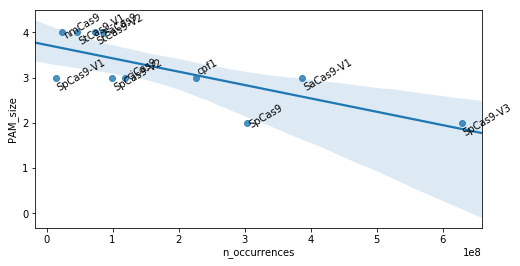

In [20]:
pam_presence_dict = np.load('/pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg38/n_pams_per_cas.npy').item()
pam_presence_df = pd.DataFrame.from_dict(pam_presence_dict, orient='index')
pam_presence_df.columns = ['n_occurrences']
pam_presence_df['Cas'] = pam_presence_df.index
cas_list = list(pam_sizes.keys())
pam_presence_df = pam_presence_df.replace(cas_dict)
pam_presence_df['in_list'] = pam_presence_df['Cas'].isin(cas_list)
pam_presence_df = pam_presence_df.query('in_list')[['n_occurrences','Cas']]
pam_presence_df['PAM_size'] = pam_presence_df.apply(lambda row: pam_sizes[row['Cas']], axis=1)

pam_presence_df.sort_values(by='n_occurrences', ascending=False)

# plot relationship of PAM size to presence in genome
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
p = sns.regplot('n_occurrences', 'PAM_size', data=pam_presence_df, ci=95)
counter = -1
for cas in pam_presence_df.Cas.tolist():
    counter += 1
    if cas == 'cjCas9':
        p.annotate(cas, xy=(pam_presence_df.n_occurrences.tolist()[counter],pam_presence_df.PAM_size.tolist()[counter]),
              rotation=30, xytext=(pam_presence_df.n_occurrences.tolist()[counter]+0.6,
                                   pam_presence_df.PAM_size.tolist()[counter]+0.28))
    else:
        p.annotate(cas, xy=(pam_presence_df.n_occurrences.tolist()[counter],pam_presence_df.PAM_size.tolist()[counter]),
              rotation=30, xytext=(pam_presence_df.n_occurrences.tolist()[counter],
                                   pam_presence_df.PAM_size.tolist()[counter]+0.28))

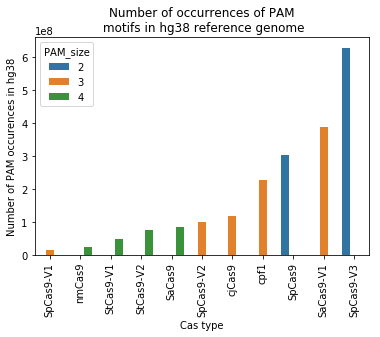

In [21]:
sns.barplot(x='Cas',y='n_occurrences',hue='PAM_size',data=pam_presence_df.sort_values(by='n_occurrences'))
plt.xticks(rotation=90)
plt.ylabel('Number of PAM occurences in hg38')
plt.xlabel('Cas type')
plt.title('Number of occurrences of PAM\n motifs in hg38 reference genome')